# Task 2 - Aspect Based Sentiment Analysis
The goal of this task is to perform Aspect-Based Sentiment Analysis (ABSA). Students will use the same train.json and val.json files as in Task 1 but will preprocess them differently.


In [3]:
import json
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)



### 2.2 Preprocessing

In [4]:
with open('train.json', 'r') as file:
    train_data = json.load(file)

print(train_data)


[{'sentence_id': '3121', 'sentence': 'But the staff was so horrible to us.', 'aspect_terms': [{'term': 'staff', 'polarity': 'negative', 'from': '8', 'to': '13'}], 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '2777', 'sentence': "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", 'aspect_terms': [{'term': 'food', 'polarity': 'positive', 'from': '57', 'to': '61'}], 'aspect_categories': [{'category': 'food', 'polarity': 'positive'}, {'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}]}, {'sentence_id': '1634', 'sentence': "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'aspect_terms': [{'term': 'food', 'polarity': 'positive', 'from': '4', 'to': '8'}, {'term': 'kitchen', 'polarity': 'positive', 'from': '55', 'to': '62'}, {'ter

In [5]:
with open('val.json', 'r') as file:
    val_data = json.load(file)

print(val_data)

[{'sentence_id': '3510', 'sentence': 'I was here a few weeks back and we had the worst customer service experience at a restaurant ever.', 'aspect_terms': [{'term': 'customer service', 'polarity': 'negative', 'from': '49', 'to': '65'}], 'aspect_categories': [{'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}, {'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '3030', 'sentence': "(I've ordered from the 2nd ave.", 'aspect_terms': [], 'aspect_categories': [{'category': 'anecdotes/miscellaneous', 'polarity': 'neutral'}]}, {'sentence_id': '1320', 'sentence': 'Nothing against a good sales call, but the tactics at Amma are just too obvious.', 'aspect_terms': [], 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}]}, {'sentence_id': '328', 'sentence': 'Went on a 3 day oyster binge, with Fish bringing up the closing, and I am so glad this was the place it O trip ended, because it was so great!', 'aspect_terms': [{'term': 'place', 'polarity': 'posi

In [6]:
def tokenize_sentence(sentence):
    # Remove all non-alphanumeric characters except spaces
    clean_sentence = re.sub(r'[^\w\s]', '', sentence)
    # Tokenize using split
    tokens = clean_sentence.split()
    return tokens

'''# Process each entry in the dataset
for entry in train_data:
    original_sentence = entry['sentence']
    tokens = process_sentence(original_sentence)

    print(f"Original: {original_sentence}")
    print(f"Tokenized: {tokens}")
    print(f"Token count: {len(tokens)}")
    print("-" * 50)'''

'# Process each entry in the dataset\nfor entry in train_data:\n    original_sentence = entry[\'sentence\']\n    tokens = process_sentence(original_sentence)\n\n    print(f"Original: {original_sentence}")\n    print(f"Tokenized: {tokens}")\n    print(f"Token count: {len(tokens)}")\n    print("-" * 50)'

In [7]:
def preprocess_data(data):

    processed_data = []

    # Process each entry in the dataset
    for entry in data:
        original_sentence = entry['sentence']
        tokens = tokenize_sentence(original_sentence)

        # Process each aspect term in the entry
        for aspect_term in entry['aspect_terms']:
            term = aspect_term['term']
            polarity = aspect_term['polarity']

            # Find the index of the aspect term in the tokenized list
            # We need to find the closest match since removing symbols might affect positions
            term_tokens = tokenize_sentence(term)

            # Find the first token of the aspect term in the tokenized sentence
            index = -1
            for i, token in enumerate(tokens):
                if token.lower() == term_tokens[0].lower():
                    # For multi-word aspect terms, check if subsequent tokens match
                    if len(term_tokens) == 1 or all(i+j < len(tokens) and tokens[i+j].lower() == term_tokens[j].lower() for j in range(1, len(term_tokens))):
                        index = i
                        break

            # Create a new entry
            processed_entry = {
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': term_tokens,
                'index': index
            }

            processed_data.append(processed_entry)

    return processed_data


In [8]:
train_final = preprocess_data(train_data)
with open('train_task2.json', 'w') as file:
    json.dump(train_final, file, indent=2)

print(f"Processed {len(train_final)} aspect terms from {len(train_data)} sentences.")
print("Data saved to train_task2.json")

Processed 2961 aspect terms from 2435 sentences.
Data saved to train_task2.json


In [9]:
val_final = preprocess_data(val_data)
with open('val_task2.json', 'w') as file:
    json.dump(val_final, file, indent=2)

print(f"Processed {len(val_final)} aspect terms from {len(val_data)} sentences.")
print("Data saved to val_task2.json")

Processed 371 aspect terms from 304 sentences.
Data saved to val_task2.json


In [10]:
class ABSADataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Extract sentence tokens and aspect terms
        tokens = sample['tokens']
        aspect_terms = sample['aspect_term']  # List of aspect terms
        aspect_indices = sample['index']  # List of indices

        # Handle case where aspect_terms or indices might not be a list
        if not isinstance(aspect_terms, list):
            aspect_terms = [aspect_terms]
        if not isinstance(aspect_indices, list):
            aspect_indices = [aspect_indices]

        # Convert polarity to numerical value - add 'conflict' to the mapping
        polarity_mapping = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}

        # Handle polarity value
        if isinstance(sample['polarity'], list):
            polarity = polarity_mapping[sample['polarity'][0]]  # Take first polarity if it's a list
        else:
            polarity = polarity_mapping[sample['polarity']]  # Direct mapping if it's not a list

        # Create sentence from tokens
        sentence = ' '.join(tokens)

        # Tokenize the sentence using BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Create an aspect position mask
        aspect_mask = torch.zeros(self.max_len)

        # For this specific case where we know the aspect is 5 consecutive tokens starting from index 5
        # We directly mark positions 6, 7, 8, 9, 10 (accounting for [CLS] token at position 0)
        start_idx = aspect_indices[0] + 1  # +1 for [CLS] token

        # Set exactly 5 consecutive positions to 1
        for i in range(len(aspect_terms)):
            pos = start_idx + i
            if pos < self.max_len:
                aspect_mask[pos] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'aspect_mask': aspect_mask,
            'polarity': torch.tensor(polarity, dtype=torch.long)
        }

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        assert self.head_dim * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"

        # Query, Key, Value projections for all heads
        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)

        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections and reshape
        q = self.q_linear(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_linear(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_linear(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)  # Add head dimensions
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)

        # Reshape and concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_dim)

        # Final linear layer
        output = self.out_proj(context)

        return output, attn_weights

class AspectPositionEmbedding(nn.Module):
    def __init__(self, max_len, embedding_dim):
        super().__init__()
        self.pos_embeddings = nn.Embedding(2 * max_len + 1, embedding_dim)

    def forward(self, batch_size, seq_len, aspect_indices):
        # Create position indices relative to aspect terms
        pos_indices = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(aspect_indices.device)
        relative_positions = pos_indices - aspect_indices.unsqueeze(1)

        # Shift positions to be positive for embedding lookup
        max_len = self.pos_embeddings.weight.size(0) // 2
        relative_positions = relative_positions.clamp(-max_len, max_len) + max_len

        # Get position embeddings
        position_embeddings = self.pos_embeddings(relative_positions)
        return position_embeddings

class ImprovedABSAModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_heads=8, max_len=128, n_layers=2):
        super().__init__()

        self.bert = bert_model
        self.embedding_dim = bert_model.config.hidden_size

        # Bidirectional GRU layer
        self.gru = nn.GRU(
            self.embedding_dim,
            hidden_dim // 2,  # Half the hidden size for bidirectional
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True
        )

        # Position embeddings
        self.position_embedding = AspectPositionEmbedding(max_len, hidden_dim)

        # Multi-head attention layers
        self.aspect_to_context_attention = MultiHeadAttention(hidden_dim, num_heads)
        self.context_to_aspect_attention = MultiHeadAttention(hidden_dim, num_heads)

        # Final layers
        self.fusion_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        batch_size = input_ids.size(0)

        # Convert aspect_mask to aspect_indices
        # For each example, find the positions where aspect_mask is 1
        aspect_indices = torch.zeros(batch_size, dtype=torch.long, device=input_ids.device)
        for i in range(batch_size):
            # Find the positions where aspect_mask is 1
            # If multiple positions, take the mean position
            aspect_positions = torch.nonzero(aspect_mask[i]).squeeze(-1)
            if aspect_positions.numel() > 0:
                aspect_indices[i] = aspect_positions.float().mean().long()

        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        # Use the last hidden state from BERT
        embedded = bert_outputs.last_hidden_state

        # Pass through bidirectional GRU
        gru_outputs, _ = self.gru(embedded)

        # Generate aspect position embeddings
        position_embedded = self.position_embedding(batch_size, gru_outputs.size(1), aspect_indices)

        # Add position embeddings to GRU outputs
        enhanced_representation = gru_outputs + position_embedded

        # Use the provided aspect_mask for aspect representation
        # Expand aspect mask for proper broadcasting
        expanded_aspect_mask = aspect_mask.unsqueeze(-1).expand_as(enhanced_representation)

        # Extract aspect representations
        aspect_representation = (enhanced_representation * expanded_aspect_mask).sum(dim=1, keepdim=True)
        aspect_representation = aspect_representation / (aspect_mask.sum(dim=1, keepdim=True).unsqueeze(-1) + 1e-10)

        # Apply multi-head attention mechanisms
        # 1. Aspect-to-context attention
        a2c_output, _ = self.aspect_to_context_attention(
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            enhanced_representation,
            enhanced_representation,
            attention_mask
        )

        # 2. Context-to-aspect attention
        c2a_output, _ = self.context_to_aspect_attention(
            enhanced_representation,
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            aspect_representation.expand(-1, enhanced_representation.size(1), -1),
            attention_mask
        )

        # Combine the attention outputs
        combined_attention = torch.cat([a2c_output, c2a_output], dim=-1)

        # Fusion layer
        fused_representation = torch.tanh(self.fusion_layer(combined_attention))

        # Get sentence representation - weighted average using attention mask
        masked_representation = fused_representation * attention_mask.unsqueeze(-1)
        sentence_representation = masked_representation.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        # Final classification
        output = self.output_layer(sentence_representation)

        return output




In [12]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, text, adj):
        batch_size, seq_len, _ = text.size()

        # Apply weight transformation
        support = torch.matmul(text, self.weight)

        # Apply graph convolution for each item in batch
        output = torch.zeros_like(support)
        for i in range(batch_size):
            output[i] = torch.matmul(adj[i], support[i])

        if self.bias is not None:
            output = output + self.bias

        return output

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output, mask=None):
        # lstm_output shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention scores
        attention_scores = self.attention(lstm_output).squeeze(-1)  # (batch_size, seq_len)

        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)

        # Apply attention weights to the input
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output)  # (batch_size, 1, hidden_dim)

        return context_vector.squeeze(1), attention_weights


class DependencyGraphBuilder:
    def __init__(self, max_seq_length):
        self.max_seq_length = max_seq_length

    def build_adjacency_matrix(self, dependency_tree, seq_length):

        # Initialize adjacency matrix with identity matrix (self-loops)
        adj = np.eye(self.max_seq_length)

        # Add edges for dependencies
        for head, dependent, _ in dependency_tree:
            if head < self.max_seq_length and dependent < self.max_seq_length:
                # Add bidirectional edges
                adj[head, dependent] = 1
                adj[dependent, head] = 1

        # Normalize adjacency matrix
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = np.diag(d_inv_sqrt)
        adj = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

        return torch.FloatTensor(adj)

class GraphBasedSentimentModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, gcn_layers, output_dim):
        super(GraphBasedSentimentModel, self).__init__()

        # BERT for token embeddings
        self.bert = bert_model
        self.embedding_dim = bert_model.config.hidden_size

        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GraphConvolution(self.embedding_dim, hidden_dim))
        for _ in range(gcn_layers - 1):
            self.gcn_layers.append(GraphConvolution(hidden_dim, hidden_dim))

        # BiLSTM layer
        self.lstm = nn.LSTM(
            self.embedding_dim,
            hidden_dim // 2,
            batch_first=True,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = AttentionLayer(hidden_dim)

        # Fusion layer to combine GCN and LSTM outputs
        self.fusion = nn.Linear(hidden_dim * 2, hidden_dim)

        # Output layer for sentiment prediction
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        # Graph builder to create adjacency matrices
        self.max_seq_length = 128  # Same as ABSADataset max_len
        self.graph_builder = None  # Will be initialized when needed

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        """
        Updated forward method to match the train_model_batch and evaluate_model functions

        Args:
            input_ids: Tensor of shape (batch_size, seq_len)
            attention_mask: Tensor of shape (batch_size, seq_len)
            token_type_ids: Tensor of shape (batch_size, seq_len)
            aspect_mask: Tensor of shape (batch_size, seq_len)

        Returns:
            Tensor of shape (batch_size, output_dim) with sentiment predictions
        """
        batch_size = input_ids.size(0)
        seq_length = input_ids.size(1)
        device = input_ids.device

        # Generate adjacency matrices
        adj_matrices = self.create_default_adjacency_matrices(batch_size, seq_length, device)

        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        # Use the last hidden state from BERT
        embedded = bert_outputs.last_hidden_state

        # Apply GCN layers
        gcn_output = embedded
        for gcn_layer in self.gcn_layers:
            gcn_output = F.relu(gcn_layer(gcn_output, adj_matrices))

        # Get aspect-specific GCN representation using the aspect mask
        # First, ensure aspect_mask has the right shape
        aspect_mask = aspect_mask.float()  # Convert to float for multiplication

        # Calculate weighted sum of GCN outputs based on aspect mask
        # Method 1: Using batch matrix multiplication
        # First, reshape aspect_mask to be compatible with bmm
        # aspect_mask shape: [batch_size, seq_len] -> [batch_size, 1, seq_len]
        aspect_mask_expanded = aspect_mask.unsqueeze(1)

        # Perform batch matrix multiplication
        # [batch_size, 1, seq_len] x [batch_size, seq_len, hidden_dim] -> [batch_size, 1, hidden_dim]
        aspect_gcn_rep = torch.bmm(aspect_mask_expanded, gcn_output).squeeze(1)

        # Normalize by the sum of aspect mask values
        aspect_mask_sum = aspect_mask.sum(dim=1, keepdim=True) + 1e-10
        aspect_gcn_rep = aspect_gcn_rep / aspect_mask_sum

        # Apply BiLSTM
        lstm_output, _ = self.lstm(embedded)

        # Apply attention mechanism with attention mask
        context_vector, _ = self.attention(lstm_output, attention_mask)

        # Combine GCN and LSTM representations
        combined = torch.cat([aspect_gcn_rep, context_vector], dim=1)
        fused = torch.tanh(self.fusion(combined))

        # Final prediction
        output = self.output_layer(fused)

        return output

    def create_default_adjacency_matrices(self, batch_size, seq_length, device):
        """
        Creates default adjacency matrices (fully connected graph)
        In a real scenario, these would come from a dependency parser

        Args:
            batch_size: Number of samples in the batch
            seq_length: Length of each sequence
            device: Device to place the tensors on

        Returns:
            Tensor of shape (batch_size, seq_length, seq_length)
        """
        # Create identity matrix (self-loops)
        adj = torch.eye(seq_length).unsqueeze(0).repeat(batch_size, 1, 1)

        # Add connections to make a fully connected graph
        adj = adj + 0.1 * torch.ones_like(adj)

        # Normalize adjacency matrix
        rowsum = adj.sum(dim=2, keepdim=True)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = d_inv_sqrt.expand_as(adj)
        adj = adj * d_mat_inv_sqrt * d_mat_inv_sqrt.transpose(1, 2)

        return adj.to(device)

    def initialize_graph_builder(self, max_seq_length=None):
        """
        Initialize the graph builder for dependency parsing

        Args:
            max_seq_length: Maximum sequence length for the adjacency matrix
        """
        if max_seq_length is None:
            max_seq_length = self.max_seq_length

        self.graph_builder = DependencyGraphBuilder(max_seq_length)

In [13]:
class TD_LSTM_GCN(nn.Module):
    def __init__(self, pretrained_bert="bert-base-uncased", hidden_dim=256, output_dim=4, num_gcn_layers=2):
        super(TD_LSTM_GCN, self).__init__()

        # BERT encoder
        self.bert = BertModel.from_pretrained(pretrained_bert)
        bert_output_dim = self.bert.config.hidden_size

        # TD-LSTM components
        self.lstm_left = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_right = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_target = nn.LSTM(bert_output_dim, hidden_dim, batch_first=True, bidirectional=True)

        # GCN components
        self.gcn_layers = nn.ModuleList([
            GraphConvolution(bert_output_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_gcn_layers)
        ])

        # Attention mechanism for combining LSTM and GCN outputs
        self.attention_lstm = nn.Linear(hidden_dim * 2, 1)
        self.attention_gcn = nn.Linear(hidden_dim, 1)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 3, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask, dependency_matrix=None):
        """
        input_ids: [batch_size, seq_len] - Input token ids from BERT tokenizer
        attention_mask: [batch_size, seq_len] - Attention mask from BERT tokenizer
        token_type_ids: [batch_size, seq_len] - Token type ids from BERT tokenizer
        aspect_mask: [batch_size, seq_len] - Binary mask indicating aspect positions
        dependency_matrix: [batch_size, seq_len, seq_len] - Adjacency matrix from dependency parsing
                          If None, we'll create a simple approximation
        """
        batch_size, seq_len = input_ids.size()

        # Get BERT embeddings
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        embedded = bert_outputs.last_hidden_state  # [batch_size, seq_len, bert_dim]

        # If dependency matrix is not provided, create an approximation
        if dependency_matrix is None:
            # Create a simple approximation - nearby words are connected
            dependency_matrix = torch.zeros(batch_size, seq_len, seq_len, device=input_ids.device)
            for i in range(seq_len):
                # Connect word to itself and adjacent words
                for j in range(max(0, i-1), min(seq_len, i+2)):
                    dependency_matrix[:, i, j] = 1.0

            # Mask out padding tokens
            dependency_matrix = dependency_matrix * attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)

        # Find aspect term positions
        aspect_start_indices = []
        aspect_end_indices = []
        aspect_lengths = []

        for i in range(batch_size):
            # Find the indices where aspect_mask is 1
            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]
            if len(aspect_indices) > 0:
                aspect_start_indices.append(aspect_indices[0].item())
                aspect_end_indices.append(aspect_indices[-1].item())
                aspect_lengths.append(len(aspect_indices))
            else:
                # Fallback if no aspect is found - point to a safe position
                # Point to the first non-padding token (using [CLS] token position)
                aspect_start_indices.append(0)
                aspect_end_indices.append(0)
                aspect_lengths.append(1)

        # Process with TD-LSTM
        left_outputs = []
        right_outputs = []
        target_outputs = []

        for i in range(batch_size):
            # Create attention masks for valid tokens
            valid_mask = attention_mask[i].bool()
            valid_token_count = valid_mask.sum().item()

            # Left context (words before target)
            left_idx = aspect_start_indices[i]
            # Ensure there's actually content in the left context (at least 1 token)
            if left_idx > 1 and (left_idx - 1) > 0:  # If there's a left context (account for [CLS])
                left_input = embedded[i, 1:left_idx].unsqueeze(0)  # [1, left_len, bert_dim]
                if left_input.size(1) > 0:  # Double check if sequence is not empty
                    _, (h_left, _) = self.lstm_left(left_input)
                    left_outputs.append(h_left.squeeze(0))
                else:
                    # Empty left context, use zero vector
                    left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))
            else:
                # No left context, use zero vector
                left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))

            # Right context (words after target)
            right_idx = aspect_end_indices[i]
            right_limit = valid_token_count - 1  # Last valid token (exclude [SEP])

            # Ensure there's actually content in the right context (at least 1 token)
            if right_idx < right_limit and (right_limit - right_idx - 1) > 0:
                right_input = embedded[i, right_idx+1:right_limit].flip(dims=[0]).unsqueeze(0)
                if right_input.size(1) > 0:  # Double check if sequence is not empty
                    _, (h_right, _) = self.lstm_right(right_input)
                    right_outputs.append(h_right.squeeze(0))
                else:
                    # Empty right context, use zero vector
                    right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))
            else:
                # No right context, use zero vector
                right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))

            # Target aspect
            if aspect_lengths[i] > 0 and aspect_start_indices[i] < aspect_end_indices[i] + 1:
                target_input = embedded[i, aspect_start_indices[i]:aspect_end_indices[i]+1].unsqueeze(0)
                if target_input.size(1) > 0:  # Check if sequence is not empty
                    target_output, _ = self.lstm_target(target_input)
                    # Pooling over target words
                    target_pooled = F.max_pool1d(target_output.transpose(1, 2), target_input.size(1)).squeeze(2)
                    target_outputs.append(target_pooled)
                else:
                    # Empty target, use zero vector
                    target_outputs.append(torch.zeros(1, self.lstm_target.hidden_size * 2, device=embedded.device))
            else:
                # This happens with invalid or empty aspects
                # Use [CLS] token as fallback for aspect representation
                cls_token = embedded[i, 0].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, bert_dim]
                target_output, _ = self.lstm_target(cls_token)
                target_pooled = target_output.squeeze(1)  # Shape: [1, hidden_dim*2]
                target_outputs.append(target_pooled)

        # Stack the outputs
        left_hidden = torch.cat(left_outputs, dim=0)  # [batch_size, hidden_dim//2]
        right_hidden = torch.cat(right_outputs, dim=0)  # [batch_size, hidden_dim//2]
        target_hidden = torch.cat(target_outputs, dim=0)  # [batch_size, hidden_dim*2]

        # Process with GCN to capture syntactic dependencies
        gcn_output = embedded
        for gcn_layer in self.gcn_layers:
            gcn_output = gcn_layer(gcn_output, dependency_matrix)
            gcn_output = F.relu(gcn_output)

        # Extract aspect-specific GCN representations with safe handling for empty aspects
        aspect_gcn_outputs = []
        for i in range(batch_size):
            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]
            if len(aspect_indices) > 0:
                # Get GCN outputs at aspect positions
                aspect_gcn = gcn_output[i, aspect_indices]  # [aspect_len, hidden_dim]
                # Pool over aspect words
                aspect_gcn_pooled = torch.mean(aspect_gcn, dim=0)  # [hidden_dim]
                aspect_gcn_outputs.append(aspect_gcn_pooled.unsqueeze(0))
            else:
                # Fallback - use [CLS] token representation when no aspect is found
                aspect_gcn_outputs.append(gcn_output[i, 0].unsqueeze(0))

        aspect_gcn_hidden = torch.cat(aspect_gcn_outputs, dim=0)  # [batch_size, hidden_dim]

        # Combine TD-LSTM hidden states
        td_lstm_hidden = torch.cat([left_hidden, right_hidden], dim=1)  # [batch_size, hidden_dim]

        # Attention-based fusion of representations
        lstm_score = torch.sigmoid(self.attention_lstm(target_hidden))  # [batch_size, 1]
        gcn_score = torch.sigmoid(self.attention_gcn(aspect_gcn_hidden))  # [batch_size, 1]

        alpha = lstm_score / (lstm_score + gcn_score + 1e-10)  # [batch_size, 1]
        combined_hidden = alpha * td_lstm_hidden + (1 - alpha) * aspect_gcn_hidden

        # Final representation
        final_hidden = torch.cat([combined_hidden, target_hidden], dim=1)  # [batch_size, hidden_dim*3]

        # Classification
        output = self.fc(final_hidden)
        return output


class GraphConvolution(nn.Module):
    """
    Graph Convolutional Layer for capturing syntactic dependencies
    """
    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.bias = nn.Parameter(torch.FloatTensor(output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        """
        x: [batch_size, seq_len, input_dim]
        adj: [batch_size, seq_len, seq_len]
        """
        batch_size, seq_len, _ = x.size()

        # Add self-loops to the adjacency matrix
        adj = adj + torch.eye(seq_len).unsqueeze(0).expand(batch_size, -1, -1).to(x.device)

        # Normalize adjacency matrix (D^-1/2 A D^-1/2)
        deg = torch.sum(adj, dim=2, keepdim=True)
        norm_adj = adj / torch.sqrt(deg + 1e-10) / torch.sqrt(deg.transpose(1, -1) + 1e-10)

        # Apply graph convolution
        support = torch.matmul(x, self.weight)  # [batch_size, seq_len, output_dim]
        output = torch.matmul(norm_adj, support) + self.bias

        return output



In [14]:
def train_model_batch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(data_loader):
        # Get data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        aspect_mask = batch['aspect_mask'].to(device)
        polarity = batch['polarity'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

        # Calculate loss and backpropagate
        loss = criterion(predictions, polarity)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = predictions.argmax(dim=1)
        acc = (preds == polarity).float().mean()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [15]:
# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in data_loader:
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            polarity = batch['polarity'].to(device)

            # Forward pass
            predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

            # Calculate loss and accuracy
            loss = criterion(predictions, polarity)
            preds = predictions.argmax(dim=1)
            acc = (preds == polarity).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)



In [16]:
def train_model(model, train_dataloader, val_dataloader, device, lr_given, n_epochs):
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr_given)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # n_epochs = 21
    best_val_loss = float('inf')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Train and evaluate
        train_loss, train_acc = train_model_batch(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.5f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.5f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-absa-model.pt')
            print('Best model saved!')

        print()
    return train_losses, train_accs, val_losses, val_accs




In [17]:
def plot(train_losses, train_accs, val_losses, val_accs):
  # Plot training curves
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Train Acc')
  plt.plot(val_accs, label='Val Acc')
  plt.ylim(0, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.savefig('training_curves.png')
  plt.show()

In [18]:
# Load the JSON file
with open("train_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Assuming it's a list of dictionaries

# Keep only the top 200 entries
train_final_data = data

In [19]:
# Load the JSON file
with open("val_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Assuming it's a list of dictionaries

# Keep only the top 200 entries
val_final_data = data

In [20]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create datasets and dataloaders
train_dataset = ABSADataset(train_final_data, tokenizer)
val_dataset = ABSADataset(val_final_data, tokenizer)



# Print the first few samples from train_dataset
for i in range(5):  # Adjust the range as needed
    print(f"Sample {i}: {train_dataset[i]}\n")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Sample 0: {'input_ids': tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [21]:
batch_size = 32
output_dim = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



Initializing model...
Starting training...
Epoch 1/21


100%|██████████| 93/93 [00:22<00:00,  4.13it/s]


Train Loss: 0.951 | Train Acc: 60.93651%
Val Loss: 0.915 | Val Acc: 64.47368%
Best model saved!

Epoch 2/21


100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Train Loss: 0.734 | Train Acc: 70.96181%
Val Loss: 0.835 | Val Acc: 66.03618%
Best model saved!

Epoch 3/21


100%|██████████| 93/93 [00:23<00:00,  4.01it/s]


Train Loss: 0.656 | Train Acc: 74.45248%
Val Loss: 0.794 | Val Acc: 67.33827%
Best model saved!

Epoch 4/21


100%|██████████| 93/93 [00:22<00:00,  4.06it/s]


Train Loss: 0.623 | Train Acc: 75.75506%
Val Loss: 0.821 | Val Acc: 68.11952%

Epoch 5/21


100%|██████████| 93/93 [00:22<00:00,  4.18it/s]


Train Loss: 0.584 | Train Acc: 76.99439%
Val Loss: 0.802 | Val Acc: 68.29770%

Epoch 6/21


100%|██████████| 93/93 [00:22<00:00,  4.13it/s]


Train Loss: 0.538 | Train Acc: 78.78321%
Val Loss: 0.860 | Val Acc: 68.11952%

Epoch 7/21


100%|██████████| 93/93 [00:22<00:00,  4.07it/s]


Train Loss: 0.514 | Train Acc: 79.75372%
Val Loss: 0.853 | Val Acc: 65.69353%

Epoch 8/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.464 | Train Acc: 82.81942%
Val Loss: 0.871 | Val Acc: 65.09046%

Epoch 9/21


100%|██████████| 93/93 [00:22<00:00,  4.11it/s]


Train Loss: 0.438 | Train Acc: 83.38275%
Val Loss: 0.836 | Val Acc: 68.73629%

Epoch 10/21


100%|██████████| 93/93 [00:22<00:00,  4.09it/s]


Train Loss: 0.414 | Train Acc: 84.44220%
Val Loss: 0.873 | Val Acc: 69.51754%

Epoch 11/21


100%|██████████| 93/93 [00:22<00:00,  4.09it/s]


Train Loss: 0.357 | Train Acc: 86.49589%
Val Loss: 0.956 | Val Acc: 70.12061%

Epoch 12/21


100%|██████████| 93/93 [00:22<00:00,  4.09it/s]


Train Loss: 0.324 | Train Acc: 88.44877%
Val Loss: 0.904 | Val Acc: 71.25822%

Epoch 13/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.304 | Train Acc: 89.51613%
Val Loss: 0.981 | Val Acc: 69.17489%

Epoch 14/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.280 | Train Acc: 89.61694%
Val Loss: 1.099 | Val Acc: 69.51754%

Epoch 15/21


100%|██████████| 93/93 [00:22<00:00,  4.11it/s]


Train Loss: 0.265 | Train Acc: 89.93517%
Val Loss: 0.993 | Val Acc: 70.90186%

Epoch 16/21


100%|██████████| 93/93 [00:22<00:00,  4.11it/s]


Train Loss: 0.231 | Train Acc: 91.71213%
Val Loss: 1.139 | Val Acc: 69.77796%

Epoch 17/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.206 | Train Acc: 92.50672%
Val Loss: 1.213 | Val Acc: 67.35197%

Epoch 18/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.199 | Train Acc: 92.77554%
Val Loss: 1.197 | Val Acc: 70.38103%

Epoch 19/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.170 | Train Acc: 94.02672%
Val Loss: 1.183 | Val Acc: 69.77796%

Epoch 20/21


100%|██████████| 93/93 [00:22<00:00,  4.10it/s]


Train Loss: 0.149 | Train Acc: 94.83318%
Val Loss: 1.235 | Val Acc: 69.86020%

Epoch 21/21


100%|██████████| 93/93 [00:22<00:00,  4.09it/s]


Train Loss: 0.138 | Train Acc: 95.13164%
Val Loss: 1.259 | Val Acc: 68.73629%



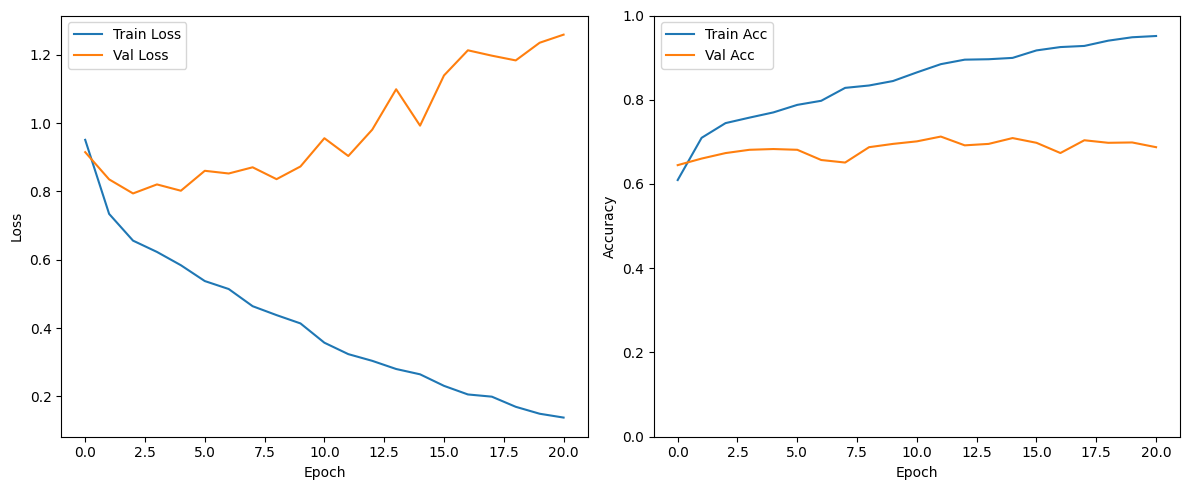

Training complete!


In [23]:
hidden_dim = 256
num_heads = 4
max_len = 128
n_layers = 2

print("Initializing model...")
model = ImprovedABSAModel(
        bert_model,
        hidden_dim,
        output_dim,
        num_heads=num_heads,
        max_len=max_len,
        n_layers=n_layers,
    )
model = model.to(device)

# Train and evaluate model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
        model,
        train_dataloader,
        val_dataloader,
        device, lr_given = 1e-4, n_epochs=21
    )

# Plot training and validation metrics
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")


Initializing model...
Starting training...
Epoch 1/21


100%|██████████| 93/93 [00:19<00:00,  4.65it/s]


Train Loss: 0.972 | Train Acc: 60.30202%
Val Loss: 0.923 | Val Acc: 61.95175%
Best model saved!

Epoch 2/21


100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


Train Loss: 0.754 | Train Acc: 69.94584%
Val Loss: 0.845 | Val Acc: 66.03618%
Best model saved!

Epoch 3/21


100%|██████████| 93/93 [00:20<00:00,  4.54it/s]


Train Loss: 0.681 | Train Acc: 73.57092%
Val Loss: 0.808 | Val Acc: 68.11952%
Best model saved!

Epoch 4/21


100%|██████████| 93/93 [00:20<00:00,  4.52it/s]


Train Loss: 0.632 | Train Acc: 75.98237%
Val Loss: 0.814 | Val Acc: 67.33827%

Epoch 5/21


100%|██████████| 93/93 [00:20<00:00,  4.46it/s]


Train Loss: 0.603 | Train Acc: 76.72162%
Val Loss: 0.794 | Val Acc: 68.37993%
Best model saved!

Epoch 6/21


100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


Train Loss: 0.570 | Train Acc: 78.10326%
Val Loss: 0.801 | Val Acc: 68.21546%

Epoch 7/21


100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


Train Loss: 0.547 | Train Acc: 78.03210%
Val Loss: 0.783 | Val Acc: 71.42270%
Best model saved!

Epoch 8/21


100%|██████████| 93/93 [00:21<00:00,  4.43it/s]


Train Loss: 0.511 | Train Acc: 79.78732%
Val Loss: 0.832 | Val Acc: 68.37993%

Epoch 9/21


100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


Train Loss: 0.485 | Train Acc: 81.39627%
Val Loss: 0.812 | Val Acc: 67.59868%

Epoch 10/21


100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


Train Loss: 0.451 | Train Acc: 82.90046%
Val Loss: 0.815 | Val Acc: 69.59978%

Epoch 11/21


100%|██████████| 93/93 [00:21<00:00,  4.34it/s]


Train Loss: 0.437 | Train Acc: 83.10207%
Val Loss: 0.812 | Val Acc: 69.07895%

Epoch 12/21


100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Train Loss: 0.397 | Train Acc: 84.61812%
Val Loss: 0.838 | Val Acc: 68.64035%

Epoch 13/21


100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Train Loss: 0.380 | Train Acc: 85.08065%
Val Loss: 0.840 | Val Acc: 69.42160%

Epoch 14/21


100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Train Loss: 0.368 | Train Acc: 85.79420%
Val Loss: 0.861 | Val Acc: 69.42160%

Epoch 15/21


100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Train Loss: 0.351 | Train Acc: 86.73110%
Val Loss: 0.876 | Val Acc: 67.85910%

Epoch 16/21


100%|██████████| 93/93 [00:21<00:00,  4.26it/s]


Train Loss: 0.320 | Train Acc: 87.14224%
Val Loss: 0.919 | Val Acc: 67.25603%

Epoch 17/21


100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Train Loss: 0.308 | Train Acc: 87.67592%
Val Loss: 1.043 | Val Acc: 66.99561%

Epoch 18/21


100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Train Loss: 0.300 | Train Acc: 88.28076%
Val Loss: 0.932 | Val Acc: 67.07785%

Epoch 19/21


100%|██████████| 93/93 [00:21<00:00,  4.26it/s]


Train Loss: 0.260 | Train Acc: 90.16643%
Val Loss: 0.915 | Val Acc: 67.68092%

Epoch 20/21


100%|██████████| 93/93 [00:21<00:00,  4.25it/s]


Train Loss: 0.256 | Train Acc: 90.36409%
Val Loss: 0.952 | Val Acc: 68.11952%

Epoch 21/21


100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Train Loss: 0.237 | Train Acc: 90.76731%
Val Loss: 0.972 | Val Acc: 68.90077%



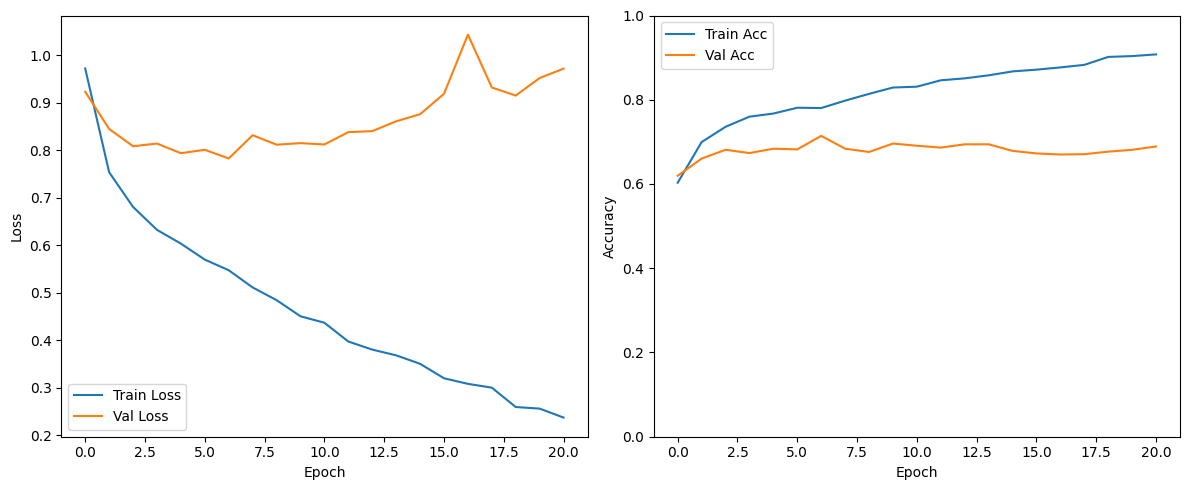

Training complete!


In [24]:
# Model hyperparameters
max_seq_length = 128
hidden_dim = 256
gcn_layers = 2


# Initialize model
print("Initializing model...")
model = GraphBasedSentimentModel(
        bert_model=bert_model,
        hidden_dim=hidden_dim,
        gcn_layers=gcn_layers,
        output_dim=output_dim)

model.initialize_graph_builder(max_seq_length=max_seq_length)

    # Move model to device
model = model.to(device)

    # Train the model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device, lr_given = 1e-4, n_epochs=21
    )

    # Plot training results
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")

Initializing model...
Starting training...
Epoch 1/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.757 | Train Acc: 69.85689%
Val Loss: 0.707 | Val Acc: 73.24561%
Best model saved!

Epoch 2/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.457 | Train Acc: 83.04673%
Val Loss: 0.669 | Val Acc: 74.80811%
Best model saved!

Epoch 3/10


100%|██████████| 93/93 [01:08<00:00,  1.36it/s]


Train Loss: 0.268 | Train Acc: 90.70011%
Val Loss: 0.809 | Val Acc: 73.24561%

Epoch 4/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.177 | Train Acc: 94.72842%
Val Loss: 0.902 | Val Acc: 72.28618%

Epoch 5/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.111 | Train Acc: 96.44213%
Val Loss: 0.968 | Val Acc: 74.20504%

Epoch 6/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.078 | Train Acc: 97.61820%
Val Loss: 0.957 | Val Acc: 74.62993%

Epoch 7/10


100%|██████████| 93/93 [01:08<00:00,  1.36it/s]


Train Loss: 0.058 | Train Acc: 98.25269%
Val Loss: 1.016 | Val Acc: 74.80811%

Epoch 8/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.045 | Train Acc: 98.55511%
Val Loss: 0.973 | Val Acc: 74.54770%

Epoch 9/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.037 | Train Acc: 98.72707%
Val Loss: 1.113 | Val Acc: 73.24561%

Epoch 10/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.028 | Train Acc: 98.82392%
Val Loss: 1.318 | Val Acc: 72.98520%



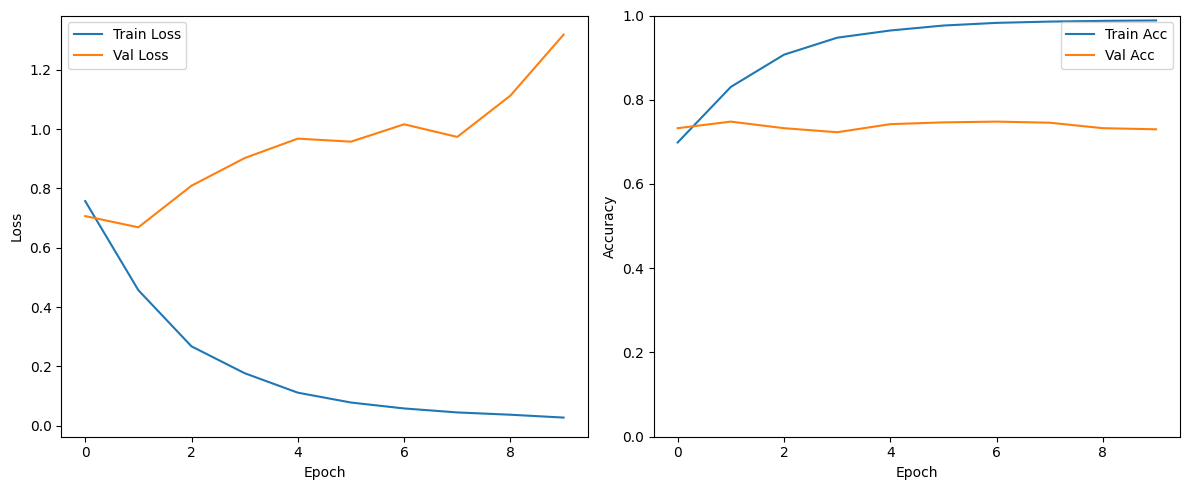

Training complete!


In [25]:
# 75%

# Model hyperparameters
max_seq_length = 128
hidden_dim = 256
gcn_layers = 2

# Initialize model
print("Initializing model...")
model = TD_LSTM_GCN(
    hidden_dim=hidden_dim,
    num_gcn_layers=gcn_layers,
    output_dim=output_dim)

model = model.to(device)

# Train the model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device, lr_given = 3e-5, n_epochs=10)


# Plot training results
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")


# Additional Task

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from transformers import BartModel, BartTokenizer
from transformers import RobertaModel, RobertaTokenizer
from tqdm import tqdm


class BERTForABSA(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased", output_dim=4):
        super(BERTForABSA, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get the [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Pass through classifier
        logits = self.classifier(pooled_output)
        return logits

class BARTForABSA(nn.Module):
    def __init__(self, pretrained_model="facebook/bart-base", output_dim=4):
        super(BARTForABSA, self).__init__()
        self.bart = BartModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bart.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        # BART doesn't use token_type_ids, so we ignore it
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get the first token representation (equivalent to [CLS] in BERT)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Pass through classifier
        logits = self.classifier(pooled_output)
        return logits

class RoBERTaForABSA(nn.Module):
    def __init__(self, pretrained_model="roberta-base", output_dim=4):
        super(RoBERTaForABSA, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask):
        # RoBERTa doesn't use token_type_ids, so we ignore it
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get the first token representation (equivalent to [CLS] in BERT)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Pass through classifier
        logits = self.classifier(pooled_output)
        return logits


In [ ]:
# Load preprocessed data
with open("train_task2.json", "r", encoding="utf-8") as file:
    train_final_data = json.load(file)
with open("val_task2.json", "r", encoding="utf-8") as file:
    val_final_data = json.load(file)

# Initialize tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset_bert = ABSADataset(train_final_data, bert_tokenizer)
val_dataset_bert = ABSADataset(val_final_data, bert_tokenizer)

train_dataset_bart = ABSADataset(train_final_data, bart_tokenizer)
val_dataset_bart = ABSADataset(val_final_data, bart_tokenizer)

train_dataset_roberta = ABSADataset(train_final_data, roberta_tokenizer)
val_dataset_roberta = ABSADataset(val_final_data, roberta_tokenizer)

# Create dataloaders
train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_dataloader_bert = DataLoader(val_dataset_bert, batch_size=32, shuffle=False)

train_dataloader_bart = DataLoader(train_dataset_bart, batch_size=32, shuffle=True)
val_dataloader_bart = DataLoader(val_dataset_bart, batch_size=32, shuffle=False)

train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=32, shuffle=True)
val_dataloader_roberta = DataLoader(val_dataset_roberta, batch_size=32, shuffle=False)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dim = 4  # Number of polarity classes (negative, neutral, positive, conflict)

bert_model = BERTForABSA(output_dim=output_dim).to(device)
bart_model = BARTForABSA(output_dim=output_dim).to(device)
roberta_model = RoBERTaForABSA(output_dim=output_dim).to(device)

# Fine-tune and evaluate BERT
print("Fine-tuning BERT...")
bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs = train_model(
    model=bert_model,
    train_dataloader=train_dataloader_bert,
    val_dataloader=val_dataloader_bert,
    device=device,
    lr_given=1e-5,
    n_epochs=10
)
plot(bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs)

# Fine-tune and evaluate BART
print("Fine-tuning BART...")
bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs = train_model(
    model=bart_model,
    train_dataloader=train_dataloader_bart,
    val_dataloader=val_dataloader_bart,
    device=device,
    lr_given=2e-4,
    n_epochs=10
)
plot(bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs)

# Fine-tune and evaluate RoBERTa
print("Fine-tuning RoBERTa...")
roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs = train_model(
    model=roberta_model,
    train_dataloader=train_dataloader_roberta,
    val_dataloader=val_dataloader_roberta,
    device=device,
    lr_given=2e-4,
    n_epochs=10
)
plot(roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT...
Epoch 1/10


100%|██████████| 93/93 [00:57<00:00,  1.63it/s]


Train Loss: 0.897 | Train Acc: 63.42307%
Val Loss: 0.842 | Val Acc: 68.73629%
Best model saved!

Epoch 2/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 0.647 | Train Acc: 75.04941%
Val Loss: 0.766 | Val Acc: 69.77796%
Best model saved!

Epoch 3/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 0.551 | Train Acc: 78.71600%
Val Loss: 0.736 | Val Acc: 67.43421%
Best model saved!

Epoch 4/10


100%|██████████| 93/93 [00:57<00:00,  1.62it/s]


Train Loss: 0.476 | Train Acc: 81.92995%
Val Loss: 0.759 | Val Acc: 68.37993%

Epoch 5/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 0.445 | Train Acc: 82.57234%
Val Loss: 0.758 | Val Acc: 68.29770%

Epoch 6/10


100%|██████████| 93/93 [00:57<00:00,  1.60it/s]


Train Loss: 0.390 | Train Acc: 84.08049%
Val Loss: 0.779 | Val Acc: 67.59868%

Epoch 7/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 0.365 | Train Acc: 84.82764%
Val Loss: 0.766 | Val Acc: 68.90077%

Epoch 8/10


 53%|█████▎    | 49/93 [00:30<00:27,  1.60it/s]